In [ ]:
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# verify data
%ls drive/MyDrive/training_data/quadrant_enumeration/

coco_quadrant_enumeration_2048_1024.json  masks_quadrant_2048_2048/        xrays/
coco_quadrant_enumeration_2048_2048.json  masks_teeth_2048_1024/           xrays_2048_1024/
explore_unet.pth                          masks_teeth_2048_2048/           xrays_2048_2048/
masks_quadrant_2048_1024/                 train_quadrant_enumeration.json  yolo_2048_2048/


In [ ]:
!nvidia-smi

Sat Dec  7 20:16:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional as TF
from PIL import Image, ImageDraw
import numpy as np
import os
import json


class MaskRCNNDataset(Dataset):
    def __init__(self, image_dir, coco_json, transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing images.
            coco_json (str): Path to the COCO-format JSON file.
            transform (callable, optional): Transformation to apply to images and masks.
        """
        self.image_dir = image_dir
        self.transform = transform

        with open(coco_json, "r") as f:
            coco_data = json.load(f)

        # Group annotations by image_id
        self.image_info = {img["id"]: img for img in coco_data["images"]}
        self.image_annotations = {img_id: [] for img_id in self.image_info.keys()}
        for annotation in coco_data["annotations"]:
            self.image_annotations[annotation["image_id"]].append(annotation)

        # Use only image IDs for indexing
        self.image_ids = list(self.image_info.keys())
        print(f"Dataset initialized with {len(self.image_ids)} images.")

    def __getitem__(self, index):
        """
        Args:
            index (int): Index of the image to retrieve.

        Returns:
            tuple: (image, target) where:
                - image: Tensor of the image.
                - target: Dictionary containing bounding boxes, labels, masks, and image_id.
        """
        image_id = self.image_ids[index]
        image_name = self.image_info[image_id]["file_name"]
        image_path = os.path.join(self.image_dir, image_name)

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Prepare targets
        annotations = self.image_annotations[image_id]
        boxes = []
        labels = []
        masks = []

        for annotation in annotations:
            # Bounding box
            bbox = annotation["bbox"]  # COCO format: [x_min, y_min, width, height]
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            boxes.append([x_min, y_min, x_max, y_max])

            # Class label
            labels.append(annotation["category_id"] + 1) #data is 0-indexed, Mask RCNN expects 1-indexing

            # Segmentation mask
            segmentation = annotation["segmentation"]
            mask = Image.new("L", image.size, 0)  # Default background class is 0, mask CRNN operates on binary classifiers
            draw = ImageDraw.Draw(mask)
            points = np.array(segmentation).reshape(-1, 2)
            draw.polygon([tuple(p) for p in points], fill=1)
            masks.append(np.array(mask, dtype=np.uint8))

        if not annotations:  # No objects in this image
            boxes = torch.empty((0, 4), dtype=torch.float32)  # No bounding boxes
            labels = torch.empty((0,), dtype=torch.int64)     # No labels
            masks = torch.empty((0, *image.size[::-1]), dtype=torch.uint8)  # No masks

        # Convert lists to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        if masks:
            masks = np.stack(masks)  # Efficient stacking of masks
            masks = torch.tensor(masks, dtype=torch.uint8)
        else:
            masks = torch.empty((0, *image.size[::-1]), dtype=torch.uint8)  # Handle no masks case

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([image_id], dtype=torch.int64),
        }

        # Apply transformations
        if self.transform:
            image, target = self.transform(image, target)
        else:
            image = TF.to_tensor(image)

        return image, target

    def __len__(self):
        return len(self.image_ids)


In [ ]:
from torch.optim import Adam
from torchvision.models.detection import MaskRCNN

# def train_maskrcnn(model, train_loader, val_loader, epochs, device):
#     model = model.to(device)
#     optimizer = Adam(model.parameters(), lr=1e-3)

#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0.0
#         for images, targets in train_loader:
#             images = [img.to(device) for img in images]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             optimizer.zero_grad()
#             loss_dict = model(images, targets)  # Returns a dictionary of losses
#             losses = sum(loss for loss in loss_dict.values())
#             losses.backward()
#             optimizer.step()

#             train_loss += losses.item()

#         train_loss /= len(train_loader)
#         print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

#         # # Validation step
#         # model.eval()
#         # val_loss = 0.0
#         # with torch.no_grad():
#         #     for images, targets in val_loader:
#         #         images = [img.to(device) for img in images]
#         #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         #         loss_dict = model(images, targets)
#         #         losses = sum(loss for loss in loss_dict.values())
#         #         val_loss += losses.item()

#         # val_loss /= len(val_loader)
#         # print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")


def train_maskrcnn(model, train_loader, val_loader, epochs, device):
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-4)  # Lower learning rate

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        loss_dict_sum = {}

        for images, targets in train_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            # Monitor individual losses
            for k, v in loss_dict.items():
                loss_dict_sum[k] = loss_dict_sum.get(k, 0) + v.item()

            losses = sum(loss for loss in loss_dict.values())
            if not torch.isfinite(losses):
                print(f"Loss is {losses}, stopping training")
                print(loss_dict)
                break

            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()

            train_loss += losses.item()

        # Print detailed loss components
        avg_losses = {k: v / len(train_loader) for k, v in loss_dict_sum.items()}
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Total Loss: {train_loss/len(train_loader):.4f}")
        for k, v in avg_losses.items():
            print(f"{k}: {v:.4f}")

In [ ]:
def validate_dataset(dataset):
    issues_found = False
    for idx in range(len(dataset)):
        try:
            # Retrieve an image and its target
            image, target = dataset[idx]
            # print(f"Processing image {idx}: {image}")
            print(f"Processing image {idx}")

            # Check image dimensions
            if image.size(1) == 0 or image.size(2) == 0:
                print(f"Image {idx} has invalid dimensions: {image.size()}")
                issues_found = True

            # Check bounding boxes
            for box in target["boxes"]:
                if any(coord < 0 for coord in box) or box[2] <= box[0] or box[3] <= box[1]:
                    print(f"Image {idx} has invalid bounding box: {box}")
                    issues_found = True

            # Check segmentation masks
            if target["masks"].shape[1:] != image.shape[1:]:
                print(f"Image {idx} has mismatched mask size: {target['masks'].shape} vs {image.shape[1:]}")
                issues_found = True

            # Check labels
            if any(label < 0 or label > 32 for label in target["labels"]):
                print(f"Image {idx} has invalid label: {target['labels']}")
                issues_found = True

        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            issues_found = True

    if not issues_found:
        print("All dataset items look valid!")
    else:
        print("Issues found in the dataset.")


In [ ]:
import torchvision

# Initialize Mask R-CNN model with ResNet-50 backbone
model = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=33)  # 32 teeth + background
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# model = torchvision.models.detection.maskrcnn_resnet50_fpn(
#     pretrained=True,
#     num_classes=33,
#     pretrained_backbone=True
# )

# # Optionally freeze backbone layers
# for param in model.backbone.parameters():
#     param.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


Using device: cuda


In [ ]:
from torch.utils.data import DataLoader
# Paths
base_dir = "drive/MyDrive/training_data/quadrant_enumeration"
image_dir = os.path.join(base_dir, "xrays_2048_1024")
coco_json = os.path.join(base_dir, "coco_quadrant_enumeration_2048_1024.json")

# Dataset and DataLoader
dataset = MaskRCNNDataset(image_dir, coco_json)

# from torchvision import transforms as T

# class Compose:
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, image, target):
#         for t in self.transforms:
#             image, target = t(image, target)
#         return image, target

# transform = Compose([
#     T.ToTensor(),
#     T.RandomHorizontalFlip(0.5)
# ])

# dataset = MaskRCNNDataset(image_dir, coco_json, transform=transform)

# validate_dataset(dataset)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Training
epochs = 5
# train_maskrcnn(model, train_loader, val_loader, epochs=epochs, device=device)


Dataset initialized with 634 images.


In [ ]:
train_maskrcnn(model, train_loader, val_loader, epochs=epochs, device=device)

Epoch 1/5
Total Loss: 2.3489
loss_classifier: 0.8517
loss_box_reg: 0.7343
loss_mask: 0.5529
loss_objectness: 0.0797
loss_rpn_box_reg: 0.1303
Epoch 2/5
Total Loss: 1.5389
loss_classifier: 0.4351
loss_box_reg: 0.6167
loss_mask: 0.3711
loss_objectness: 0.0236
loss_rpn_box_reg: 0.0924
Epoch 3/5
Total Loss: 1.3081
loss_classifier: 0.3401
loss_box_reg: 0.5351
loss_mask: 0.3266
loss_objectness: 0.0212
loss_rpn_box_reg: 0.0852
Epoch 4/5
Total Loss: 1.1954
loss_classifier: 0.2997
loss_box_reg: 0.4962
loss_mask: 0.3047
loss_objectness: 0.0171
loss_rpn_box_reg: 0.0778
Epoch 5/5
Total Loss: 1.1077
loss_classifier: 0.2722
loss_box_reg: 0.4607
loss_mask: 0.2874
loss_objectness: 0.0132
loss_rpn_box_reg: 0.0742


# Evaluation

In [ ]:
import torch
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os

def save_model(model, save_path):
    """
    Save a trained PyTorch model

    Args:
        model: The trained model to save
        save_path: Path where the model will be saved
    """
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

def load_model(save_path, device):
    """
    Load a trained PyTorch model

    Args:
        save_path: Path to the saved model
        device: Device to load the model to (cuda/cpu)
    Returns:
        model: The loaded model
    """
    # Initialize the model architecture
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=33)

    # Load the saved state dict
    model.load_state_dict(torch.load(save_path, map_location=device))

    # Move model to the specified device
    model = model.to(device)

    # Set to evaluation mode
    model.eval()

    return model

def prepare_image(image_path, device):
    """
    Prepare an image for model prediction
    """
    # Load and convert to RGB if needed
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert to tensor and add batch dimension
    image_tensor = F.to_tensor(image).unsqueeze(0)
    return image.copy(), image_tensor.to(device)

class_names = ['background'] + [f'tooth_{i}' for i in range(32)]  # Adjust based on your classes

def get_prediction(model, image_tensor, confidence_threshold=0.5):
    """
    Get model predictions for an image
    """
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    return predictions[0]  # Return first item as we only predict one image

def visualize_prediction(image, prediction, confidence_threshold=0.5):
    """
    Visualize the model's predictions including masks and bounding boxes
    """
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Original image
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Prediction visualization
    ax2.imshow(image)
    ax2.set_title('Predictions')
    ax2.axis('off')

    # Get predictions above threshold
    scores = prediction['scores'].cpu()
    masks = prediction['masks'].cpu()
    boxes = prediction['boxes'].cpu()
    labels = prediction['labels'].cpu()

    keep = scores > confidence_threshold
    masks = masks[keep]
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]

    # Colors for visualization
    colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))

    # Draw each instance
    for mask, box, label, score in zip(masks, boxes, labels, scores):
        # Convert mask to numpy array
        mask = mask[0].numpy()  # Take first channel
        color = colors[label.item()]

        # Create mask overlay
        mask_overlay = np.zeros((*mask.shape, 4))
        mask_overlay[mask > 0.5] = (*color[:3], 0.3)  # Semi-transparent overlay
        ax2.imshow(mask_overlay)

        # Draw bounding box
        x1, y1, x2, y2 = box.numpy()
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                           fill=False, color=color[:3], linewidth=2)
        ax2.add_patch(rect)

        # Add label
        class_name = class_names[label.item()]
        ax2.text(x1, y1-5, f'{class_name}: {score:.2f}',
                color=color[:3], fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    return fig

def predict_and_visualize(model, image_path, device, confidence_threshold=0.5):
    """
    End-to-end prediction and visualization for a single image
    """
    # Prepare image
    original_image, image_tensor = prepare_image(image_path, device)

    # Get prediction
    prediction = get_prediction(model, image_tensor, confidence_threshold)

    # Visualize
    fig = visualize_prediction(original_image, prediction, confidence_threshold)

    return prediction, fig

# Example usage in Colab:
"""
# Save model after training
save_path = '/content/drive/MyDrive/dental_maskrcnn.pth'
save_model(model, optimizer, epoch, train_loss, save_path)

# Later, load model and make predictions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=33)
model, epoch, loss = load_model(model, save_path, device)

# Make prediction on a single image
image_path = 'path_to_your_test_image.jpg'
prediction, fig = predict_and_visualize(model, image_path, device, confidence_threshold=0.5)
plt.show()
"""

"\n# Save model after training\nsave_path = '/content/drive/MyDrive/dental_maskrcnn.pth'\nsave_model(model, optimizer, epoch, train_loss, save_path)\n\n# Later, load model and make predictions\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nmodel = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=33)\nmodel, epoch, loss = load_model(model, save_path, device)\n\n# Make prediction on a single image\nimage_path = 'path_to_your_test_image.jpg'\nprediction, fig = predict_and_visualize(model, image_path, device, confidence_threshold=0.5)\nplt.show()\n"

In [ ]:
# Save model after training
save_path = 'drive/MyDrive/training_data/quadrant_enumeration/dental_maskrcnn.pth'
save_model(model, save_path)

Model saved to drive/MyDrive/training_data/quadrant_enumeration/dental_maskrcnn.pth


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=33)
save_path = 'drive/MyDrive/training_data/quadrant_enumeration/dental_maskrcnn.pth'
model= load_model(save_path, device)

<ipython-input-4-8a20ba3c8846>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=device))


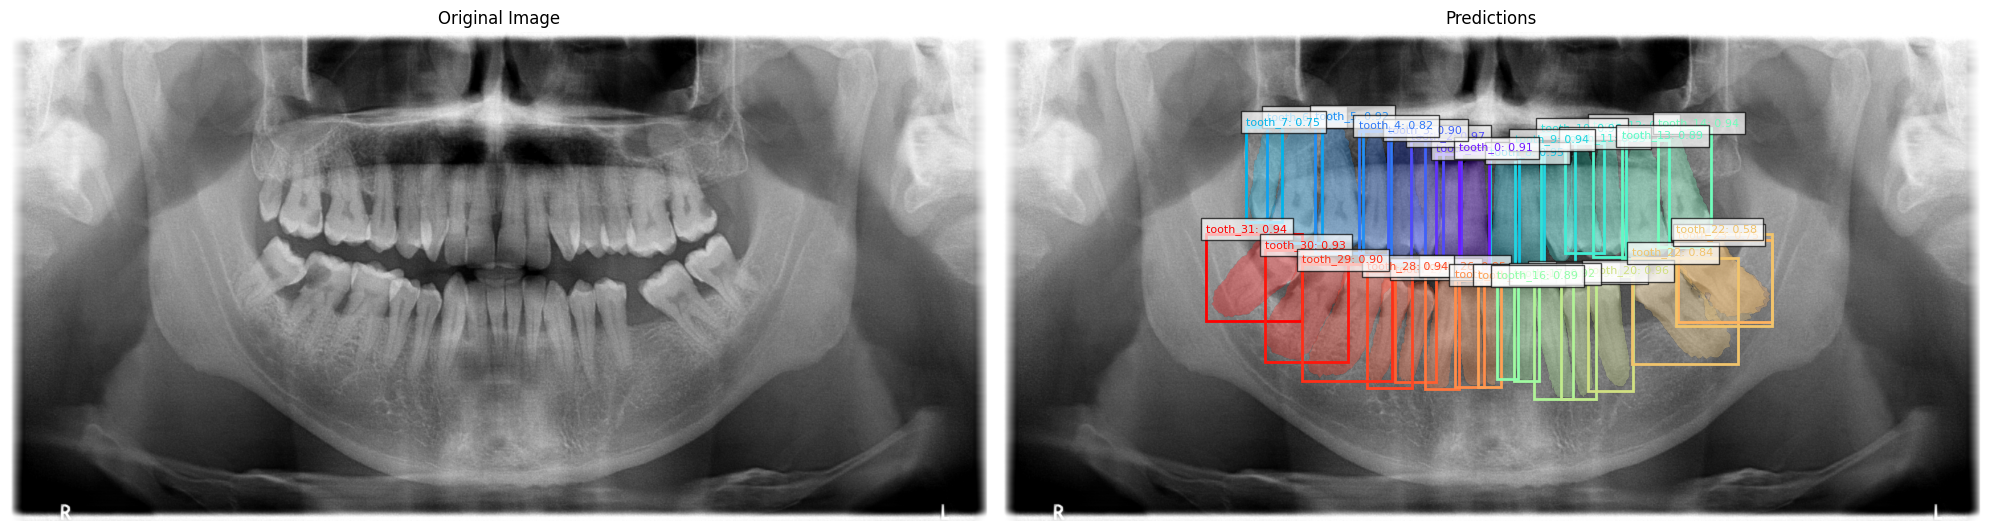

In [ ]:
image_path = 'drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_0.png'
prediction, fig = predict_and_visualize(model, image_path, device, confidence_threshold=0.5)
plt.show()

# Dice Score

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def calculate_dice_score(pred_mask, gt_mask, smooth=1e-5):
    """
    Calculate Dice score for a single prediction/ground-truth mask pair

    Args:
        pred_mask: Predicted binary mask
        gt_mask: Ground truth binary mask
        smooth: Smoothing factor to avoid division by zero
    """
    intersection = torch.sum(pred_mask * gt_mask)
    union = torch.sum(pred_mask) + torch.sum(gt_mask)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

def evaluate_model_dice(model, data_loader, device, confidence_threshold=0.5):
    """
    Evaluate model performance using Dice score

    Args:
        model: Trained Mask R-CNN model
        data_loader: DataLoader containing validation/test data
        device: Device to run evaluation on
        confidence_threshold: Threshold for considering predictions
    """
    model.eval()
    dice_scores = []
    class_dice_scores = {i: [] for i in range(32)}  # For per-tooth metrics

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            predictions = model(images)

            # Process each image in the batch
            for pred, target in zip(predictions, targets):
                pred_scores = pred['scores']
                pred_masks = pred['masks']
                pred_labels = pred['labels']

                # Filter predictions by confidence threshold
                keep = pred_scores > confidence_threshold
                pred_masks = pred_masks[keep]
                pred_labels = pred_labels[keep]

                gt_masks = target['masks']
                gt_labels = target['labels']

                # Calculate dice score for each ground truth mask
                for gt_idx, (gt_mask, gt_label) in enumerate(zip(gt_masks, gt_labels)):
                    gt_label = gt_label.item() - 1  # Convert to 0-based indexing

                    # Find predictions for this class
                    class_pred_masks = pred_masks[pred_labels == (gt_label + 1)]

                    if len(class_pred_masks) > 0:
                        # For each ground truth mask, find the best matching prediction
                        best_dice = 0
                        gt_mask_binary = (gt_mask > 0.5).float()

                        for pred_mask in class_pred_masks:
                            pred_mask_binary = (pred_mask[0] > 0.5).float()  # Take first channel
                            dice = calculate_dice_score(pred_mask_binary, gt_mask_binary)
                            best_dice = max(best_dice, dice)

                        dice_scores.append(best_dice)
                        class_dice_scores[gt_label].append(best_dice)
                    else:
                        # No prediction for this class
                        dice_scores.append(0.0)
                        class_dice_scores[gt_label].append(0.0)

    # Calculate average scores
    mean_dice = np.mean(dice_scores)

    # Calculate per-class dice scores
    class_mean_dice = {}
    for class_id, scores in class_dice_scores.items():
        if scores:  # Only calculate mean if we have scores for this class
            class_mean_dice[class_id] = np.mean(scores)

    return mean_dice, class_mean_dice


In [ ]:

# Example usage:

# Create a DataLoader for your validation/test set
val_loader = DataLoader(val_dataset,
                       batch_size=2,
                       shuffle=False,
                       collate_fn=lambda x: tuple(zip(*x)))

# Evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean_dice, class_dice = evaluate_model_dice(model, val_loader, device)

# Print results
print(f"Overall Mean Dice Score: {mean_dice:.4f}")
print("\nPer-Class Dice Scores:")
for tooth_num, dice_score in class_dice.items():
    print(f"Tooth {tooth_num}: {dice_score:.4f}")


Overall Mean Dice Score: 0.8213

Per-Class Dice Scores:
Tooth 0: 0.8254
Tooth 1: 0.8412
Tooth 2: 0.8329
Tooth 3: 0.7831
Tooth 4: 0.7246
Tooth 5: 0.7775
Tooth 6: 0.8225
Tooth 7: 0.7542
Tooth 8: 0.8325
Tooth 9: 0.8435
Tooth 10: 0.8453
Tooth 11: 0.7963
Tooth 12: 0.8059
Tooth 13: 0.7618
Tooth 14: 0.8096
Tooth 15: 0.7560
Tooth 16: 0.8272
Tooth 17: 0.8318
Tooth 18: 0.8673
Tooth 19: 0.8417
Tooth 20: 0.8314
Tooth 21: 0.8504
Tooth 22: 0.8710
Tooth 23: 0.8419
Tooth 24: 0.8142
Tooth 25: 0.8399
Tooth 26: 0.8438
Tooth 27: 0.8131
Tooth 28: 0.8285
Tooth 29: 0.8242
Tooth 30: 0.8450
Tooth 31: 0.8484


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=33):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        def up_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = up_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_block(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))

        return self.final_conv(dec1)


def load_unet_model(save_path, device):
    """
    Load a trained PyTorch U-Net model

    Args:
        save_path: Path to the saved model
        device: Device to load the model to (cuda/cpu)
    Returns:
        model: The loaded model
    """
    # Initialize the model
    model = UNet(in_channels=1, out_channels=33)

    # Load the state dict with proper file handling
    with open(save_path, 'rb') as f:
        state_dict = torch.load(f, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)

    # Move model to device
    model = model.to(device)

    # Set to evaluation mode
    model.eval()

    return model

def load_maskrcnn_model(save_path, device):
    """
    Load a trained PyTorch Mask R-CNN model

    Args:
        save_path: Path to the saved model
        device: Device to load the model to (cuda/cpu)
    Returns:
        model: The loaded model
    """
    # Initialize the model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=33)

    # Load the state dict with proper file handling
    with open(save_path, 'rb') as f:
        state_dict = torch.load(f, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)

    # Move model to device
    model = model.to(device)

    # Set to evaluation mode
    model.eval()

    return model


class HybridSegmentation:
    def __init__(self, maskrcnn_path, unet_path, device):
        """
        Initialize both models
        """
        # Load Mask R-CNN for detection
        self.maskrcnn = load_maskrcnn_model(maskrcnn_path, device)

        # Load U-Net for refined segmentation
        self.unet = load_unet_model(unet_path, device)
        self.device = device


    def predict(self, image, confidence_threshold=0.5):
        """
        Perform hybrid segmentation with corrected class mapping
        """
        if image.dim() == 4:
            image = image.squeeze(0)
        image = image.to(self.device)

        # 1. Get Mask R-CNN predictions
        with torch.no_grad():
            maskrcnn_pred = self.maskrcnn([image])[0]

        keep = maskrcnn_pred['scores'] > confidence_threshold
        boxes = maskrcnn_pred['boxes'][keep]
        labels = maskrcnn_pred['labels'][keep]

        final_masks = []

        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = map(int, box.cpu().numpy())

            roi = image[:, y1:y2, x1:x2].unsqueeze(0)

            if roi.shape[1] == 3:
                roi = 0.2989 * roi[:, 0:1] + 0.5870 * roi[:, 1:2] + 0.1140 * roi[:, 2:3]

            roi_resized = F.interpolate(roi, size=(256, 256), mode='bilinear', align_corners=False)

            # Get U-Net prediction
            unet_pred = self.unet(roi_resized)  # Shape: [1, 33, 256, 256]

            # The label from Mask R-CNN is already 1-indexed (1-32)
            # We need to convert it to 0-31 for U-Net tooth classes
            tooth_idx = label.item() - 1

            # Apply softmax to get probabilities across all classes
            probs = F.softmax(unet_pred, dim=1)

            # Get probability for this tooth vs background
            tooth_prob = probs[:, tooth_idx:tooth_idx+1]
            bg_prob = probs[:, -1:]  # Last channel (32) is background

            # Create binary mask where tooth probability > background probability
            tooth_mask = (tooth_prob > bg_prob).float()

            # Resize mask back to ROI size
            mask_resized = F.interpolate(tooth_mask, size=(y2-y1, x2-x1),
                                       mode='bilinear', align_corners=False)

            full_mask = torch.zeros((1, 1, image.shape[1], image.shape[2]),
                                  device=self.device)
            full_mask[:, :, y1:y2, x1:x2] = mask_resized

            final_masks.append(full_mask)

        if final_masks:
            final_masks = torch.cat(final_masks, dim=1)
        else:
            final_masks = torch.zeros((1, 0, image.shape[1], image.shape[2]),
                                    device=self.device)

        return {
            'boxes': boxes,
            'labels': labels,
            'masks': final_masks,
            'scores': maskrcnn_pred['scores'][keep]
        }

def post_process_masks(masks, threshold=0.5):
    """
    Post-process masks to handle overlapping regions
    """
    # Convert to binary masks
    binary_masks = (masks > threshold).float()

    # Handle overlapping regions using argmax
    if binary_masks.shape[1] > 1:  # If we have multiple instances
        # Get max confidence for each pixel across all instances
        max_vals, max_idx = torch.max(masks, dim=1, keepdim=True)

        # Create one-hot encoded masks based on argmax
        processed_masks = torch.zeros_like(masks)
        for i in range(masks.shape[1]):
            processed_masks[:, i:i+1] = (max_idx == i).float() * (max_vals > threshold).float()
    else:
        processed_masks = binary_masks

    return processed_masks

In [ ]:
# Initialize hybrid model
# hybrid_model = HybridSegmentation(
#     maskrcnn_path=
#     unet_path=
#     device=device
# )

# Initialize the hybrid model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hybrid_model = HybridSegmentation(
    maskrcnn_path="drive/MyDrive/training_data/quadrant_enumeration/dental_maskrcnn.pth",
    unet_path="drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth",
    device=device
)

# # Make prediction
# prediction = hybrid_model.predict(image_tensor)
# masks = post_process_masks(prediction['masks'])

In [ ]:
from torchvision.transforms import functional as TF  # Note this is different from torch.nn.functional
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_hybrid_predictions(hybrid_model, image_path, confidence_threshold=0.5):
    """
    Visualize predictions from the hybrid model on a single image
    """
    # Load and prepare image
    image = Image.open(image_path).convert('RGB')
    image_tensor = TF.to_tensor(image)  # Don't add batch dimension

    # Get predictions
    with torch.no_grad():
        predictions = hybrid_model.predict(image_tensor, confidence_threshold)
        if predictions['masks'].shape[1] > 0:  # Check if we have any predictions
            masks = post_process_masks(predictions['masks'])
        else:
            print("No predictions found above the confidence threshold.")
            return None

    # Rest of the visualization code remains the same
    image_np = np.array(image)
    masks_np = masks.cpu().numpy()[0]  # Remove batch dimension

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot original image
    ax1.imshow(image_np)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Plot image with overlaid masks
    ax2.imshow(image_np)

    # Generate random colors for each mask
    colors = plt.cm.rainbow(np.linspace(0, 1, len(predictions['labels'])))

    # Plot each mask
    for i, (mask, label, score) in enumerate(zip(masks_np,
                                                predictions['labels'],
                                                predictions['scores'])):
        color = colors[i][:3]  # Remove alpha channel
        mask_overlay = np.zeros((*mask.shape, 3))
        mask_overlay[mask > 0.5] = color

        # Add mask overlay with transparency
        ax2.imshow(mask_overlay, alpha=0.3)

        # Add bounding box
        box = predictions['boxes'][i].cpu().numpy()
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                           fill=False, color=color, linewidth=2)
        ax2.add_patch(rect)

        # Add label
        label_text = f"Tooth {label.item()-1}: {score.item():.2f}"
        ax2.text(box[0], box[1]-5, label_text,
                color=color, fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7))

    ax2.set_title('Hybrid Model Predictions')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return predictions



def evaluate_hybrid_model(hybrid_model, val_loader, device, confidence_threshold=0.5):
    """
    Evaluate hybrid model using Dice score
    """
    hybrid_model.maskrcnn.eval()
    hybrid_model.unet.eval()

    dice_scores = []
    class_dice_scores = {i: [] for i in range(32)}  # For per-tooth metrics

    with torch.no_grad():
        for images, targets in val_loader:
            # Process each image in the batch
            for image, target in zip(images, targets):
                # Get hybrid model predictions
                predictions = hybrid_model.predict(image.unsqueeze(0), confidence_threshold)
                pred_masks = post_process_masks(predictions['masks'])

                # Get ground truth masks and labels
                gt_masks = target['masks'].to(device)
                gt_labels = target['labels']

                # Calculate dice score for each ground truth mask
                for gt_idx, (gt_mask, gt_label) in enumerate(zip(gt_masks, gt_labels)):
                    gt_label = gt_label.item() - 1  # Convert to 0-based indexing

                    # Find predictions for this class
                    pred_indices = [i for i, l in enumerate(predictions['labels'])
                                  if l.item() == (gt_label + 1)]

                    if pred_indices:
                        # For each ground truth mask, find the best matching prediction
                        best_dice = 0
                        gt_mask_binary = (gt_mask > 0.5).float()

                        for idx in pred_indices:
                            pred_mask = pred_masks[0, idx]  # Remove batch dimension
                            pred_mask_binary = (pred_mask > 0.5).float()

                            dice = calculate_dice_score(pred_mask_binary, gt_mask_binary)
                            best_dice = max(best_dice, dice)

                        dice_scores.append(best_dice)
                        class_dice_scores[gt_label].append(best_dice)
                    else:
                        # No prediction for this class
                        dice_scores.append(0.0)
                        class_dice_scores[gt_label].append(0.0)

    # Calculate average scores
    mean_dice = np.mean(dice_scores)

    # Calculate per-class dice scores
    class_mean_dice = {}
    for class_id, scores in class_dice_scores.items():
        if scores:  # Only calculate mean if we have scores for this class
            class_mean_dice[class_id] = np.mean(scores)

    return mean_dice, class_mean_dice



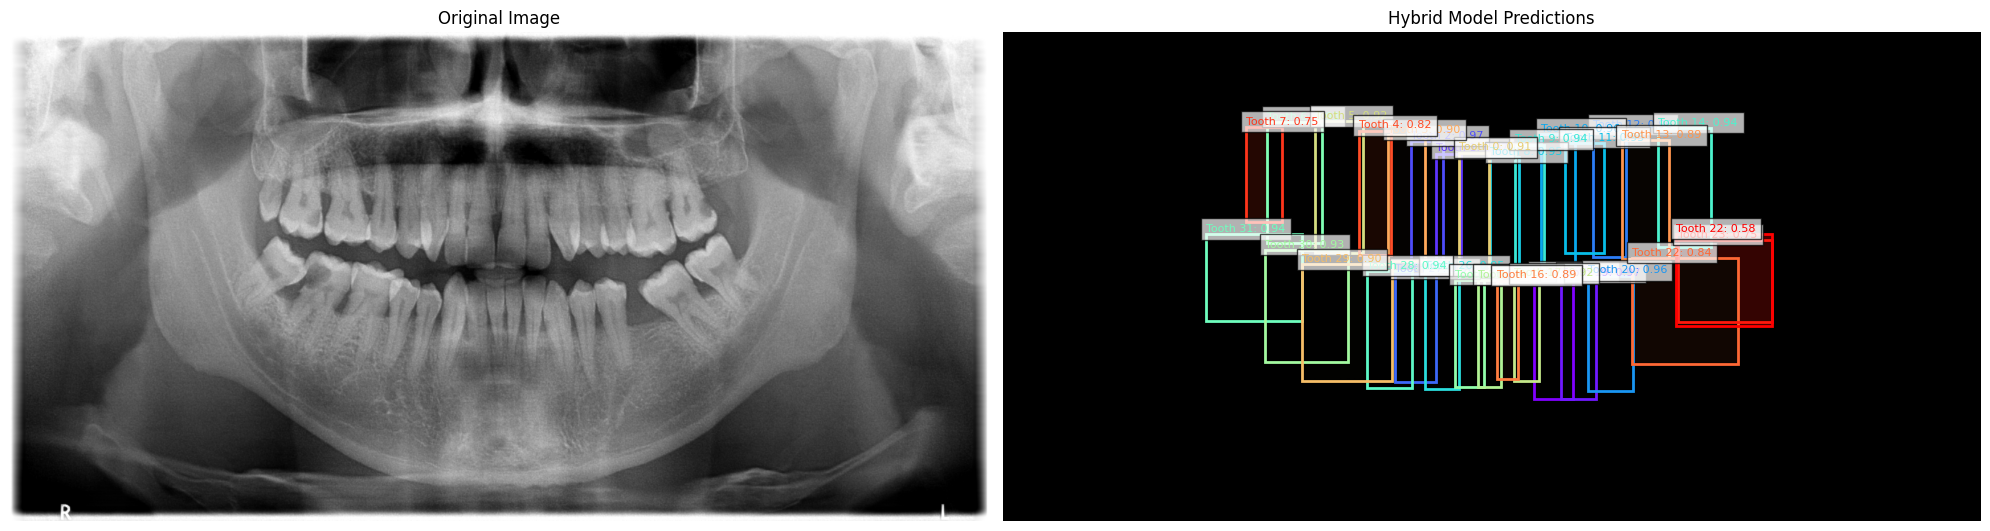

In [ ]:

# For single image visualization:
image_path = 'drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_0.png'
predictions = visualize_hybrid_predictions(hybrid_model, image_path, confidence_threshold=0.5)

# # Try it now:
# image_path = 'drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_0.png'
# predictions = visualize_hybrid_predictions(hybrid_model, image_path, confidence_threshold=0.5)


In [ ]:


# For evaluation:
mean_dice, class_dice = evaluate_hybrid_model(hybrid_model, val_loader, device)

print(f"\nOverall Mean Dice Score: {mean_dice:.4f}")
print("\nPer-Tooth Dice Scores:")
for tooth_num, dice_score in class_dice.items():
    print(f"Tooth {tooth_num}: {dice_score:.4f}")



Overall Mean Dice Score: 0.6808

Per-Tooth Dice Scores:
Tooth 0: 0.7649
Tooth 1: 0.7777
Tooth 2: 0.6643
Tooth 3: 0.6937
Tooth 4: 0.5743
Tooth 5: 0.7203
Tooth 6: 0.6968
Tooth 7: 0.4291
Tooth 8: 0.8016
Tooth 9: 0.7842
Tooth 10: 0.7359
Tooth 11: 0.6936
Tooth 12: 0.6499
Tooth 13: 0.6815
Tooth 14: 0.7095
Tooth 15: 0.5177
Tooth 16: 0.7408
Tooth 17: 0.7604
Tooth 18: 0.7727
Tooth 19: 0.7012
Tooth 20: 0.5712
Tooth 21: 0.6690
Tooth 22: 0.6080
Tooth 23: 0.4964
Tooth 24: 0.7212
Tooth 25: 0.7601
Tooth 26: 0.7564
Tooth 27: 0.6282
Tooth 28: 0.5980
Tooth 29: 0.5802
Tooth 30: 0.5828
Tooth 31: 0.6360


# **Evaluations** ----------------------------------------------------------------------

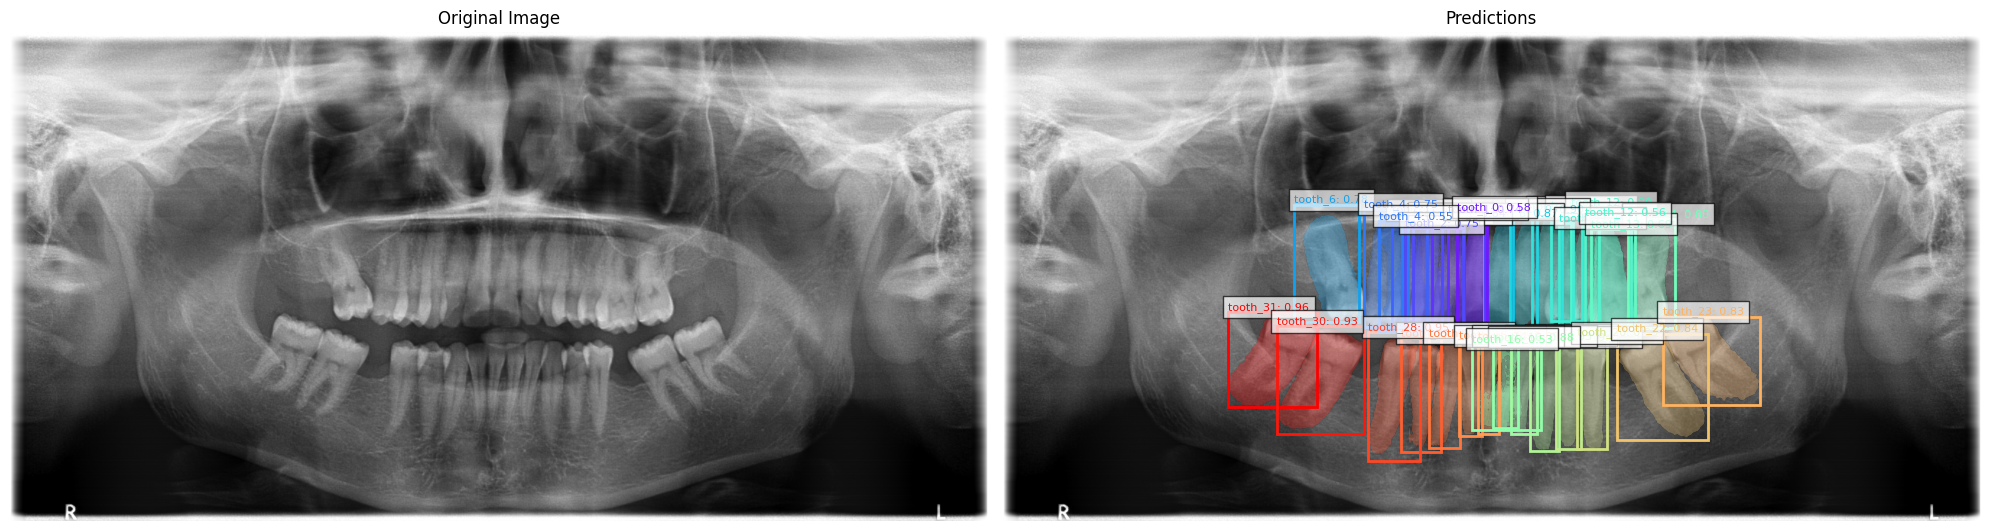

In [ ]:
image_path = 'drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_99.png'
prediction, fig = predict_and_visualize(model, image_path, device, confidence_threshold=0.5)
plt.show()

In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader

def calculate_dice_score(pred_mask, gt_mask, smooth=1e-5):
    """
    Calculate Dice score for a single prediction/ground-truth mask pair

    Args:
        pred_mask: Predicted binary mask
        gt_mask: Ground truth binary mask
        smooth: Smoothing factor to avoid division by zero
    """
    intersection = torch.sum(pred_mask * gt_mask)
    union = torch.sum(pred_mask) + torch.sum(gt_mask)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

def evaluate_model_dice(model, data_loader, device, confidence_threshold=0.5):
    """
    Evaluate model performance using Dice score

    Args:
        model: Trained Mask R-CNN model
        data_loader: DataLoader containing validation/test data
        device: Device to run evaluation on
        confidence_threshold: Threshold for considering predictions
    """
    model.eval()
    dice_scores = []
    class_dice_scores = {i: [] for i in range(32)}  # For per-tooth metrics

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            predictions = model(images)

            # Process each image in the batch
            for pred, target in zip(predictions, targets):
                pred_scores = pred['scores']
                pred_masks = pred['masks']
                pred_labels = pred['labels']

                # Filter predictions by confidence threshold
                keep = pred_scores > confidence_threshold
                pred_masks = pred_masks[keep]
                pred_labels = pred_labels[keep]

                gt_masks = target['masks']
                gt_labels = target['labels']

                # Calculate dice score for each ground truth mask
                for gt_idx, (gt_mask, gt_label) in enumerate(zip(gt_masks, gt_labels)):
                    gt_label = gt_label.item() - 1  # Convert to 0-based indexing

                    # Find predictions for this class
                    class_pred_masks = pred_masks[pred_labels == (gt_label + 1)]

                    if len(class_pred_masks) > 0:
                        # For each ground truth mask, find the best matching prediction
                        best_dice = 0
                        gt_mask_binary = (gt_mask > 0.5).float()

                        for pred_mask in class_pred_masks:
                            pred_mask_binary = (pred_mask[0] > 0.5).float()  # Take first channel
                            dice = calculate_dice_score(pred_mask_binary, gt_mask_binary)
                            best_dice = max(best_dice, dice)

                        dice_scores.append(best_dice)
                        class_dice_scores[gt_label].append(best_dice)
                    else:
                        # No prediction for this class
                        dice_scores.append(0.0)
                        class_dice_scores[gt_label].append(0.0)

    # Calculate average scores
    mean_dice = np.mean(dice_scores)

    # Calculate per-class dice scores
    class_mean_dice = {}
    for class_id, scores in class_dice_scores.items():
        if scores:  # Only calculate mean if we have scores for this class
            class_mean_dice[class_id] = np.mean(scores)

    return mean_dice, class_mean_dice


In [ ]:

# Example usage:

# Create a DataLoader for your validation/test set
val_loader = DataLoader(val_dataset,
                       batch_size=2,
                       shuffle=False,
                       collate_fn=lambda x: tuple(zip(*x)))

# Evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean_dice, class_dice = evaluate_model_dice(model, val_loader, device)

# Print results
print(f"Overall Mean Dice Score: {mean_dice:.4f}")
print("\nPer-Class Dice Scores:")
for tooth_num, dice_score in class_dice.items():
    print(f"Tooth {tooth_num}: {dice_score:.4f}")


Overall Mean Dice Score: 0.8415

Per-Class Dice Scores:
Tooth 0: 0.8353
Tooth 1: 0.8347
Tooth 2: 0.8175
Tooth 3: 0.7829
Tooth 4: 0.7567
Tooth 5: 0.7938
Tooth 6: 0.8440
Tooth 7: 0.8238
Tooth 8: 0.8414
Tooth 9: 0.8550
Tooth 10: 0.8497
Tooth 11: 0.8258
Tooth 12: 0.8191
Tooth 13: 0.8373
Tooth 14: 0.8504
Tooth 15: 0.8270
Tooth 16: 0.8257
Tooth 17: 0.8440
Tooth 18: 0.8661
Tooth 19: 0.8629
Tooth 20: 0.8652
Tooth 21: 0.8898
Tooth 22: 0.8813
Tooth 23: 0.8555
Tooth 24: 0.8286
Tooth 25: 0.8346
Tooth 26: 0.8378
Tooth 27: 0.8386
Tooth 28: 0.8608
Tooth 29: 0.8865
Tooth 30: 0.8908
Tooth 31: 0.8918


In [ ]:
# TOOTH_TYPE_MAPPING = {
#     # Universal Numbering System (0-31, adjusted from 1-32)
#     # Incisors
#     0: 'incisor', 1: 'incisor', 6: 'incisor', 7: 'incisor',  # 1,2,7,8
#     8: 'incisor', 9: 'incisor', 14: 'incisor', 15: 'incisor',  # 9,10,15,16
#     # Canines
#     2: 'canine', 5: 'canine', 10: 'canine', 13: 'canine',  # 3,6,11,14
#     # Premolars
#     3: 'premolar', 4: 'premolar', 11: 'premolar', 12: 'premolar',  # 4,5,12,13
#     19: 'premolar', 20: 'premolar', 27: 'premolar', 28: 'premolar',  # 20,21,28,29
#     # Molars
#     16: 'molar', 17: 'molar', 18: 'molar',  # 17,18,19
#     29: 'molar', 30: 'molar', 31: 'molar'  # 30,31,32
# }


TOOTH_TYPE_MAPPING = {

    # quadrant 1
    0: 'incisor', 1: 'incisor',
    2: 'canine',
    3: 'premolar', 4: 'premolar',
    5: 'molar', 6: 'molar', 7: 'molar',

    # quadrant 2
    8: 'incisor', 9: 'incisor',
    10: 'canine',
    11: 'premolar', 12: 'premolar',
    13: 'molar', 14: 'molar', 15: 'molar',

    # quadrant 3
    16: 'incisor', 17: 'incisor',
    18: 'canine',
    19: 'premolar', 20: 'premolar',
    21: 'molar', 22: 'molar', 23: 'molar',

    # quadrant 4
    24: 'incisor', 25: 'incisor',
    26: 'canine',
    27: 'premolar', 28: 'premolar',
    29: 'molar', 30: 'molar', 31: 'molar',
}

def evaluate_model_dice(model, data_loader, device, confidence_threshold=0.5):
    """
    Evaluate model performance using Dice score

    Args:
        model: Trained Mask R-CNN model
        data_loader: DataLoader containing validation/test data
        device: Device to run evaluation on
        confidence_threshold: Threshold for considering predictions
    """
    model.eval()
    dice_scores = []
    class_dice_scores = {i: [] for i in range(32)}  # For per-tooth metrics
    type_dice_scores = {
        'incisor': [],
        'canine': [],
        'premolar': [],
        'molar': []
    }

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            predictions = model(images)

            # Process each image in the batch
            for pred, target in zip(predictions, targets):
                pred_scores = pred['scores']
                pred_masks = pred['masks']
                pred_labels = pred['labels']

                # Filter predictions by confidence threshold
                keep = pred_scores > confidence_threshold
                pred_masks = pred_masks[keep]
                pred_labels = pred_labels[keep]

                gt_masks = target['masks']
                gt_labels = target['labels']

                # Calculate dice score for each ground truth mask
                for gt_idx, (gt_mask, gt_label) in enumerate(zip(gt_masks, gt_labels)):
                    gt_label = gt_label.item() - 1  # Convert to 0-based indexing

                    # Find predictions for this class
                    class_pred_masks = pred_masks[pred_labels == (gt_label + 1)]

                    if len(class_pred_masks) > 0:
                        # For each ground truth mask, find the best matching prediction
                        best_dice = 0
                        gt_mask_binary = (gt_mask > 0.5).float()

                        for pred_mask in class_pred_masks:
                            pred_mask_binary = (pred_mask[0] > 0.5).float()  # Take first channel
                            dice = calculate_dice_score(pred_mask_binary, gt_mask_binary)
                            best_dice = max(best_dice, dice)

                        dice_scores.append(best_dice)
                        class_dice_scores[gt_label].append(best_dice)
                    else:
                        # No prediction for this class
                        dice_scores.append(0.0)
                        class_dice_scores[gt_label].append(0.0)

    # Calculate average scores
    mean_dice = np.mean(dice_scores)

    # Calculate per-class dice scores
    class_mean_dice = {}
    for class_id, scores in class_dice_scores.items():
        if scores:  # Only calculate mean if we have scores for this class
            class_mean_dice[class_id] = np.mean(scores)
            # Add score to corresponding tooth type
            tooth_type = TOOTH_TYPE_MAPPING.get(class_id)
            if tooth_type:
                type_dice_scores[tooth_type].append(np.mean(scores))

    # Calculate mean dice score for each tooth type
    type_mean_dice = {}
    for tooth_type, scores in type_dice_scores.items():
        if scores:  # Only calculate mean if we have scores for this type
            type_mean_dice[tooth_type] = np.mean(scores)

    return mean_dice, class_mean_dice, type_mean_dice

# Usage:
mean_dice, class_dice, type_dice = evaluate_model_dice(model, val_loader, device)

# Print results
print(f"Overall Mean Dice Score: {mean_dice:.4f}")

print("\nDice Scores by Tooth Type:")
for tooth_type, score in type_dice.items():
    print(f"{tooth_type.capitalize()}: {score:.4f}")

print("\nDetailed Dice Scores by Class:")
for class_id, score in class_dice.items():
    tooth_type = TOOTH_TYPE_MAPPING.get(class_id, 'unknown')
    print(f"Tooth {class_id + 1} ({tooth_type}): {score:.4f}")

Overall Mean Dice Score: 0.8415

Dice Scores by Tooth Type:
Incisor: 0.8374
Canine: 0.8428
Premolar: 0.8265
Molar: 0.8560

Detailed Dice Scores by Class:
Tooth 1 (incisor): 0.8353
Tooth 2 (incisor): 0.8347
Tooth 3 (canine): 0.8175
Tooth 4 (premolar): 0.7829
Tooth 5 (premolar): 0.7567
Tooth 6 (molar): 0.7938
Tooth 7 (molar): 0.8440
Tooth 8 (molar): 0.8238
Tooth 9 (incisor): 0.8414
Tooth 10 (incisor): 0.8550
Tooth 11 (canine): 0.8497
Tooth 12 (premolar): 0.8258
Tooth 13 (premolar): 0.8191
Tooth 14 (molar): 0.8373
Tooth 15 (molar): 0.8504
Tooth 16 (molar): 0.8270
Tooth 17 (incisor): 0.8257
Tooth 18 (incisor): 0.8440
Tooth 19 (canine): 0.8661
Tooth 20 (premolar): 0.8629
Tooth 21 (premolar): 0.8652
Tooth 22 (molar): 0.8898
Tooth 23 (molar): 0.8813
Tooth 24 (molar): 0.8555
Tooth 25 (incisor): 0.8286
Tooth 26 (incisor): 0.8346
Tooth 27 (canine): 0.8378
Tooth 28 (premolar): 0.8386
Tooth 29 (premolar): 0.8608
Tooth 30 (molar): 0.8865
Tooth 31 (molar): 0.8908
Tooth 32 (molar): 0.8918


# Precision and Recall

In [ ]:
def prepare_image(image_path, device):
    """
    Prepare an image for model prediction
    """
    # Load and convert to RGB if needed
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert to tensor and add batch dimension
    image_tensor = F.to_tensor(image).unsqueeze(0)
    return image.copy(), image_tensor.to(device)

class_names = ['background'] + [f'tooth_{i}' for i in range(32)]  # Adjust based on your classes

def get_prediction(model, image_tensor, confidence_threshold=0.5):
    """
    Get model predictions for an image
    """
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    return predictions[0]  # Return first item as we only predict one image

In [ ]:
import torch
from pycocotools import mask as coco_mask
import json

def generate_predictions_json(model, val_loader, device, output_file="predictions.json"):
    """
    Generate predictions.json for COCO evaluation from a Mask R-CNN model.

    Args:
        model: The trained Mask R-CNN model.
        val_loader: DataLoader for the validation set.
        device: Device to run inference (e.g., 'cuda' or 'cpu').
        output_file: Path to save the predictions.json file.
    """
    model.to(device)
    model.eval()

    predictions = []  # List to store all predictions
    with torch.no_grad():
        for images, targets in val_loader:
            # Move images to the target device
            images = [img.to(device) for img in images]

            # Run inference
            outputs = model(images)

            for img_idx, output in enumerate(outputs):
                image_id = targets[img_idx]["image_id"].item()  # Extract image ID

                # Extract bounding boxes, labels, scores, and masks
                boxes = output["boxes"].cpu().numpy()  # Bounding boxes
                scores = output["scores"].cpu().numpy()  # Confidence scores
                labels = output["labels"].cpu().numpy()  # Class labels
                masks = output["masks"].cpu().numpy() > 0.5  # Threshold masks

                # Format each prediction
                for i in range(len(boxes)):
                    box = boxes[i]
                    score = float(scores[i])
                    label = int(labels[i])
                    mask = masks[i, 0]  # Single channel mask

                    # Convert bounding box to [x, y, width, height]
                    x_min, y_min, x_max, y_max = box
                    width = float(x_max - x_min)
                    height = float(y_max - y_min)

                    # Convert mask to RLE
                    rle = coco_mask.encode(np.asfortranarray(mask.astype(np.uint8)))

                    # Ensure RLE is JSON serializable
                    rle["counts"] = rle["counts"].decode("utf-8")

                    # Append prediction
                    predictions.append({
                        "image_id": int(image_id),
                        "category_id": int(label),
                        "bbox": [float(x_min), float(y_min), width, height],
                        "score": float(score),
                        "segmentation": rle
                    })

    # Save predictions to JSON
    with open(output_file, "w") as f:
        json.dump(predictions, f)

    print(f"Predictions saved to {output_file}")


In [ ]:
predictions_file = os.path.join(base_dir, "maskrcnn_predictions.json")
generate_predictions_json(model, val_loader, device, output_file=predictions_file)

Predictions saved to drive/MyDrive/training_data/quadrant_enumeration/maskrcnn_predictions.json


In [ ]:
import json

def filter_coco_json(gt_json_path, val_image_ids, output_path):
    """
    Filters a COCO ground truth JSON file to include only annotations for the validation set.

    Args:
        gt_json_path (str): Path to the ground truth COCO JSON file.
        val_image_ids (list): List of image IDs in the validation set.
        output_path (str): Path to save the filtered JSON file.
    """
    with open(gt_json_path, 'r') as f:
        coco_data = json.load(f)

    # Filter images
    filtered_images = [img for img in coco_data['images'] if img['id'] in val_image_ids]

    # Filter annotations
    filtered_annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] in val_image_ids]

    for ann in filtered_annotations:
        ann['category_id'] +=1

    # Update the JSON structure
    filtered_coco_data = {
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': coco_data['categories']  # Keep all categories
    }

    # Save the filtered JSON
    with open(output_path, 'w') as f:
        json.dump(filtered_coco_data, f)

    print(f"Filtered ground truth saved to {output_path}")

# Example usage:
# Assume val_loader provides a dataset object with image IDs

input_file = os.path.join(base_dir, "coco_quadrant_enumeration_2048_1024.json")
actuals_file = os.path.join(base_dir, "maskrcnn_actuals.json")

# Extract the image IDs for the validation dataset
val_image_ids = [dataset.image_ids[idx] for idx in val_dataset.indices]

filter_coco_json(input_file, val_image_ids, actuals_file)


Filtered ground truth saved to drive/MyDrive/training_data/quadrant_enumeration/maskrcnn_actuals.json


In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load ground truth annotations and predictions
coco_gt = COCO(actuals_file)
coco_pred = coco_gt.loadRes(predictions_file)

# Initialize COCOeval for bounding boxes
bbox_eval = COCOeval(coco_gt, coco_pred, iouType='bbox')
bbox_eval.evaluate()
bbox_eval.accumulate()
bbox_eval.summarize()

# Initialize COCOeval for masks
mask_eval = COCOeval(coco_gt, coco_pred, iouType='segm')
mask_eval.evaluate()
mask_eval.accumulate()
mask_eval.summarize()


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.96s).
Accumulating evaluation results...
DONE (t=0.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.516
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.588
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets